In [219]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pydotplus

# Goal: 
Analyse (using decision trees) if it’s possible to explain who had higher survival chances, based on available data. Provide recommendations for key changes, which might help to save more lives in the future 


## Workflow stages
1. Loading data
2. Quick data review
3. Exploring and data preperation
4. Visualising processed data using Pearson Correlation
5. Estimating the best tree depth with Cross Validation
6. Generating Decision Tree and Confusion Matrix
7. Generating final output for Kaggle


### 1 Loading data
Two datasets are given:
* test.csv - used on the very end to make our prediction and as a solution in the Kaggle
* train.csv - used to train our Decision Tree

In [220]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

datasets = [train, test]

PassengerId = test['PassengerId']

# show 10 rows of data
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### 2 Quick data review
Scikit Decision Trees natively support continuous data, it doesn't support the categorical natively. Because of this, we had to determine what type of data is stored in each of the columns. Also, at this stage, we checked missing data for each column and the number of unique values.



In [221]:

# checking the dimension of datasets
print('Train Dataset - Total number of rows, Number of columns: ',train.shape)

# initializing new data frame that will be displayed in the table
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', '[%] Missing Values', 'Sum Unique Val'])

# looping via columns and extracting needed information
for index, column in enumerate(train.columns):
    data_type = train.dtypes[column]
    missing_value = train[column].isnull().sum()
    percentage = round((missing_value/len(train))* 100,1) if (missing_value/len(train))* 100 else 0
    unique_val = len(train[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
data_review.head(len(data_review)) # show table

Train Dataset - Total number of rows, Number of columns:  (891, 12)


,Column,Data Type,Misssing Values,[%] Missing Values,Sum Unique Val
0,PassengerId,int64,0,0,891
1,Survived,int64,0,0,2
2,Pclass,int64,0,0,3
3,Name,object,0,0,891
4,Sex,object,0,0,2
5,Age,float64,177,19.9,89
6,SibSp,int64,0,0,7
7,Parch,int64,0,0,7
8,Ticket,object,0,0,681
9,Fare,float64,0,0,248


Pandas describe() method is used for calculating some statistical data like percentile, mean and std of the numerical values of the train dataset


In [222]:
train.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


After reviewing the data, the information stored in the columns (PassengerId, Ticket & Embarked) is considered as not relevant for our study and we decided to remove the columns from our data frames.

Columns with object datatype hold both numerical and string data. These we will need to be converted to the numerical type later on.

In [223]:
test = test.drop(['PassengerId','Ticket', 'Embarked'], axis = 1)
train = train.drop(['PassengerId','Ticket', 'Embarked'], axis = 1)

### 3 Exploring and data preperation

We explore the given data by reviewing each of the columns, in order to find any pattern. We also check the correlation between each of the features and survival.

#### Survived
0 - person died

1 - person survived

 

In [224]:
survived = train['Survived'].sum()
survived = int((survived / 891) * 100)

print(f"{survived}% of passangers survived")


38% of passangers survived


#### Pclass
We observe the correlation between class and Survival. People with tickets for the first class have a higher chance (over 60%) to survive than passengers from the second and third class.

In [225]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### Sex
Women have higher chances to survive than men.
We need to change the non-numerical data for numerical in order to use Scikit Decision Trees. We replace:
* female with 0
* male with 1

There are many different ways to do it. For example, we could use ColumnTransformer() (from scikit-learn) or get_dummies() (from pandas). However, we decide to use the simple .map() method that allows us to limit the number of columns in the data frame. 

In [226]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [227]:
# train dataset
train['Sex'] = train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# test dataset
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#### Parch & SibSp


In [228]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [229]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Since it is difficult to find any pattern having those two features, we create 2 new columns. FamilySize to keep the number of family members, and IsAlone column to indicate if a passenger travels alone or with the family.

In [230]:
# Train dataset
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1

# test dataset
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = 0
test.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
    

In [231]:
# removing SibSp and Parch from the data frames
test = test.drop(['SibSp','Parch'], axis = 1)
train = train.drop(['SibSp','Parch'], axis = 1)

We remove the 'SibSp','Parch' colummns from the train and test datasets.

In [232]:
train[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [233]:
train[["IsAlone", "Survived"]].groupby(['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


As we can see, passengers that were traveling with the family members had higher chances to survive than the passengers that were traveling alone.

#### Name 
We notice that in the Name column each of the passengers has a title that always finishes with the dot. We decided to extract this information to a new column, check the number of their occurrences, and check their correlation with the Survival.

In [234]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) # using Regular expression operations
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [235]:
unique_titles = train['Title'].unique()
unique_titles
# We have 17 unique titles in train dataset. We decided to group them
# all non-common titles are cataegorized as "Rare"
# Jonkheer i a young lord
# Countess is a historical title of nobility

#The use of Master as a prefixed title is, according to Leslie Dunkling, "a way of addressing politely a boy ... too young to be called 'Mister'." It can be used as a title and form of address for any boy. ... The title Master is still used in NHS letters concerning boys under the age of 18.
#After its replacement in common speech by Mister, Master was retained as a form of address only for boys who had not yet entered society. By the late 19th century, etiquette dictated that men be addressed as Mister, and boys as Master.
#Most titles band Age groups accurately. For example: Master title has Age mean of 5 years. Source: do not remember but it is on wikipedia as well https://en.wikipedia.org/wiki/Master_(form_of_address)

# train dataset
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

# test dataset
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')


train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Now, we can convert the categorical titles to numebers and remove the 'Name' column form the datasets as follwos:

 "Mr": 1
 
 "Miss": 2
 
 "Mrs": 3
 
 "Master": 4
 
 "Rare": 5
 

In [236]:
title_to_number = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

train['Title'] = train['Title'].map(title_to_number)
train['Title'] = train['Title'].fillna(0)
train = train.drop(['Name'], axis = 1)

test['Title'] = test['Title'].map(title_to_number)
test['Title'] = test['Title'].fillna(0)
test = test.drop(['Name'], axis = 1)

train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,FamilySize,IsAlone,Title
0,0,3,1,22.0,7.2500,NaN,2,0,1
1,1,1,0,38.0,71.2833,C85,2,0,3
2,1,3,0,26.0,7.9250,NaN,1,1,2
3,1,1,0,35.0,53.1000,C123,2,0,3
4,0,3,1,35.0,8.0500,NaN,1,1,1


#### Age
In the train data, we have 20% of passengers without the age information. Because of that, we decided to populate those empty cells. There are various ways of doing this. We decided to use one of the simplest ones based on replacing missing values with the random numbers between mean and standard deviation. It is done for both datasets.

In [237]:
# train dataset
age_avg = train['Age'].mean()
age_std = train['Age'].std()
age_null_count = train['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
train.loc[np.isnan(train['Age']), 'Age'] = age_null_random_list
train['Age'] = train['Age'].astype(int)

# test dataset
age_avg = test['Age'].mean()
age_std = test['Age'].std()
age_null_count = test['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
test.loc[np.isnan(test['Age']), 'Age'] = age_null_random_list
test['Age'] = test['Age'].astype(int)

Mapping age data into 5 categories. 
- 0 for age <= 16
- 1 for age between 16 and 32
- 2 for age between 32 and 48
- 3 for age between 48 and 64
- 4 for age over 64

In [238]:
# train 
train.loc[ train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age'] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age'] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), 'Age'] = 3
train.loc[ train['Age'] > 64, 'Age']

# test 
test.loc[ test['Age'] <= 16, 'Age'] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), 'Age'] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), 'Age'] = 2
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), 'Age'] = 3
test.loc[ test['Age'] > 64, 'Age']

81    67
96    76
Name: Age, dtype: int32

In [239]:

train = train
test = test
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,1,0.156673
1,2,0.702703
2,3,0.793651
3,4,0.575000
4,5,0.347826


Nearly 80% of people survived the catastrophe in the '2' age category - age between  32 and 48.
Children and teenagers have the lowest chances to survive - category '0'.

#### Fare
We map the fare data into 4 groups. The split is based on the calculated bands.



In [240]:
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)




,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [241]:

# train in combine:
train.loc[ train['Fare'] <= 7.91, 'Fare'] = 0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454), 'Fare'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31), 'Fare']   = 2
train.loc[ train['Fare'] > 31, 'Fare'] = 3
train['Fare'] = train['Fare'].astype(int)

# removing Null values in fare column 
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

# test in combine:
test.loc[ test['Fare'] <= 7.91, 'Fare'] = 0
test.loc[(test['Fare'] > 7.91) & (test['Fare'] <= 14.454), 'Fare'] = 1
test.loc[(test['Fare'] > 14.454) & (test['Fare'] <= 31), 'Fare']   = 2
test.loc[ test['Fare'] > 31, 'Fare'] = 3
test['Fare'] = test['Fare'].astype(int)


# removing FareBand from train dataset
train = train.drop(['FareBand'], axis=1)


#### Cabin

The null data in the cabin column indicates that the passengers didn't have a cabin. We decided that we will create a new column that replaces the cabin column and will indicate either the passenger had or didn't have a cabin. 


- 0 passenger is without a cabin
- 1 passenger has a cabin

In [242]:
train['has_cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['has_cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

In [243]:
train.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone,Title,has_cabin
0,0,3,1,1,0,2,0,1,0
1,1,1,0,2,3,2,0,3,1
2,1,3,0,1,1,1,1,2,0
3,1,1,0,2,3,2,0,3,1
4,0,3,1,2,1,1,1,1,0


### 4 Visualising processed data using Pearson Correlation

We can now use the Person correlation to visualise the relationship beween all variables. 
Using this method we plot the 'heatmap' where we can identify highest and lowest corellations between features.



<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

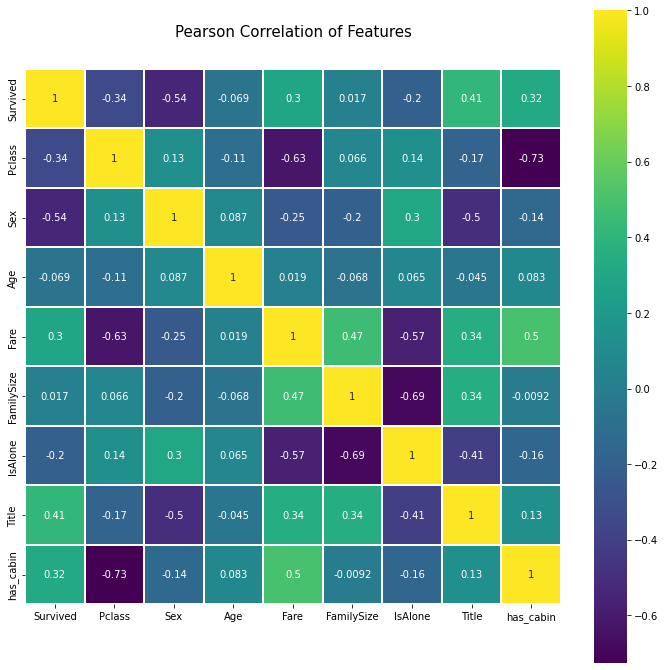

In [244]:
heatmap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=heatmap, linecolor='white', annot=True)

As we can see there are not too many features strongly correlated with one another. Meaning that that there isn't much redundant data in our datasets and we can assume that all columns contain some unique information.

The strongest correlation is between PClass and and has_cabin.


### 5. Estimating the best tree depth with Cross Validation

In [245]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.811511
         5          0.826055
         6          0.825006
         7          0.816017
         8          0.810387


As we can see after running cross-validation the accuracy doesn't change significantly after Max Depth of 3. to avoid too many fields and overfitting we decide to use the max dept 3 for our decision tree.

### Constructing decision tree
Decision tree without the Title column has score equale to 82.04

In [246]:
feature_names = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'has_cabin','Title']
drop_feature_x_train = ['Survived', 'Title']
drop_feature_x_test = ['Title']

y_train = train['Survived']
x_train = train.drop(drop_feature_x_train, axis=1).values 
x_test = test.drop(drop_feature_x_test, axis=1).values


decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print('Score: ',acc_decision_tree)
print('\nConfusion Matrix')
targ_names = ['Dead (0)', 'Survived (1)']
predictions = decision_tree.predict(x_train)
confusion_matrix(train['Survived'], predictions)

Score:  81.82

Confusion Matrix


array([[490,  59],
       [103, 239]], dtype=int64)

Decision tree with the Title column has score equale to 82.38

In [247]:

feature_names = list(train.drop(['Survived'], axis=1))
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print('Score: ',acc_decision_tree)
print('\nConfusion Matrix')
targ_names = ['Dead (0)', 'Survived (1)']
predictions = decision_tree.predict(x_train)
confusion_matrix(train['Survived'], predictions)

Score:  82.38

Confusion Matrix


array([[477,  72],
       [ 85, 257]], dtype=int64)

#### Final decision tree with the Title column

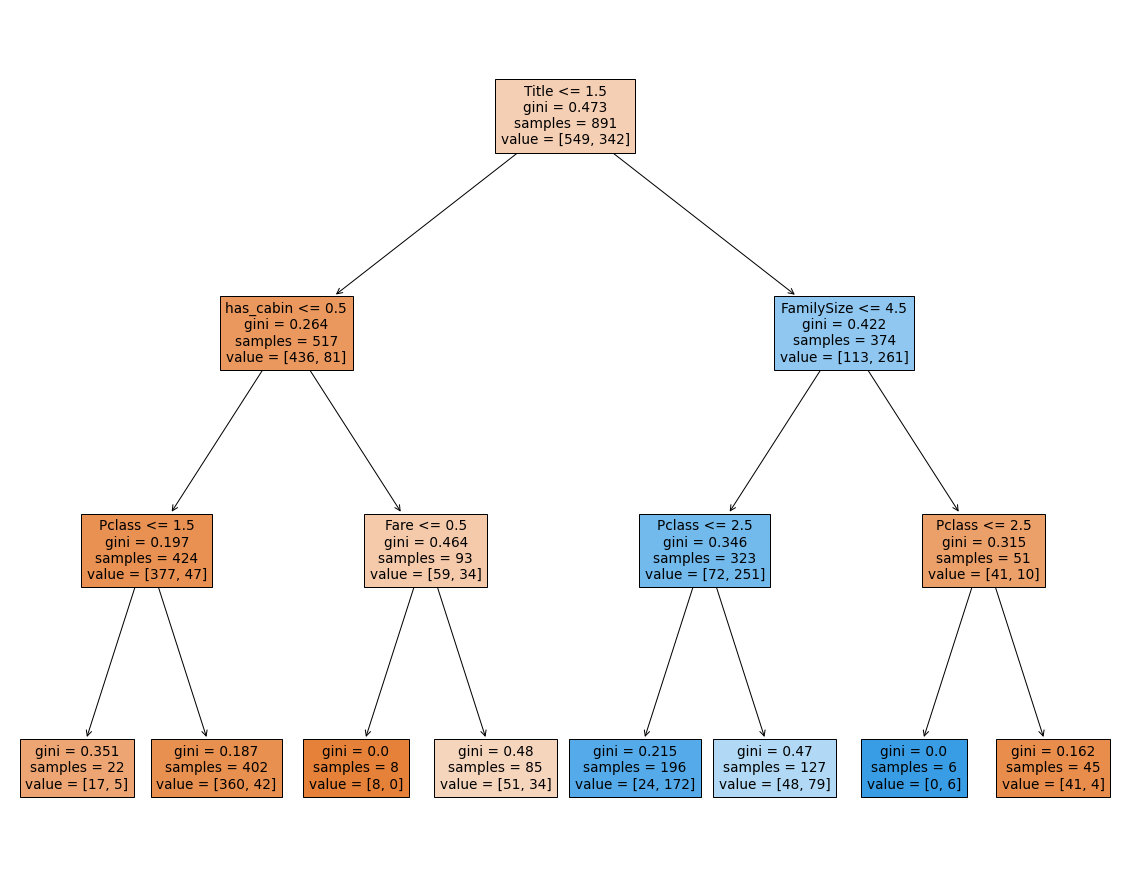

In [248]:
plt.subplots(figsize=(20, 16))
plot_tree(decision_tree,feature_names=feature_names, filled=True)
plt.show()

In [253]:
y_prediction = decision_tree.predict(x_test)

final_output_kaggle = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_prediction
    })
final_output_kaggle.to_csv('submission.csv', index=False)

